# Acoustic FWI(VP) with entire data

## Author: M. Ravasi

This notebook performs acoustic FWI parametrized in velocity using the entire dataset and multiple stages where lower frequency components are inverted first and higher frequency components are included gradually in the process. We use the ``devitofwi.fwi.acoustic.AcousticFWI2D`` driver to setup and run the entire inversion proces.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from functools import partial
from scipy.ndimage import gaussian_filter
from scipy import signal
from scipy.optimize import minimize
from pylops.basicoperators import Identity

from itertools import chain
from devito import configuration
from tqdm.notebook import tqdm

from examples.seismic import AcquisitionGeometry, Model, Receiver
from examples.seismic import plot_velocity, plot_perturbation
from examples.seismic.acoustic import AcousticWaveSolver
from examples.seismic import plot_shotrecord

from devitofwi.devito.utils import clear_devito_cache
from devitofwi.waveengine.acoustic import AcousticWave2D
from devitofwi.loss.l2 import L2
from devitofwi.postproc.acoustic import create_mask, PostProcessVP
from devitofwi.fwi.acoustic import AcousticFWI2D

configuration['log-level'] = 'ERROR'

In [2]:
clear_devito_cache()

In [3]:
# Callback to track model error
def fwi_callback(xk, vp, vp_error):
    vp_error.append(np.linalg.norm((xk - vp.reshape(-1))/vp.reshape(-1)))

## Parameters 

In [4]:
# Model and aquisition parameters
par = {'nx':601,   'dx':15,    'ox':0,
       'nz':221,   'dz':15,    'oz':0,
       'ns':20,    'ds':300,   'os':1000,  'sz':0,
       'nr':300,   'dr':30,    'or':0,     'rz':0,
       'nt':3000,  'dt':0.002, 'ot':0,
       'freq':15,
      }

# Modelling parameters
shape = (par['nx'], par['nz'])
spacing = (par['dx'], par['dz'])
origin = (par['ox'], par['oz'])
space_order = 4
nbl = 20

# Velocity model
path = '../../data/'
velocity_file = path + 'Marm.bin'

## Acquisition set-up

In [5]:
# Sampling frequency
fs = 1 / par['dt'] 

# Axes
x = np.arange(par['nx']) * par['dx'] + par['ox']
z = np.arange(par['nz']) * par['dz'] + par['oz']
t = np.arange(par['nt']) * par['dt'] + par['ot']
tmax = t[-1] * 1e3 # in ms

# Sources
x_s = np.zeros((par['ns'], 2))
x_s[:, 0] = np.arange(par['ns']) * par['ds'] + par['os']
x_s[:, 1] = par['sz']

# Receivers
x_r = np.zeros((par['nr'], 2))
x_r[:, 0] = np.arange(par['nr']) * par['dr'] + par['or']
x_r[:, 1] = par['rz']

## Velocity model

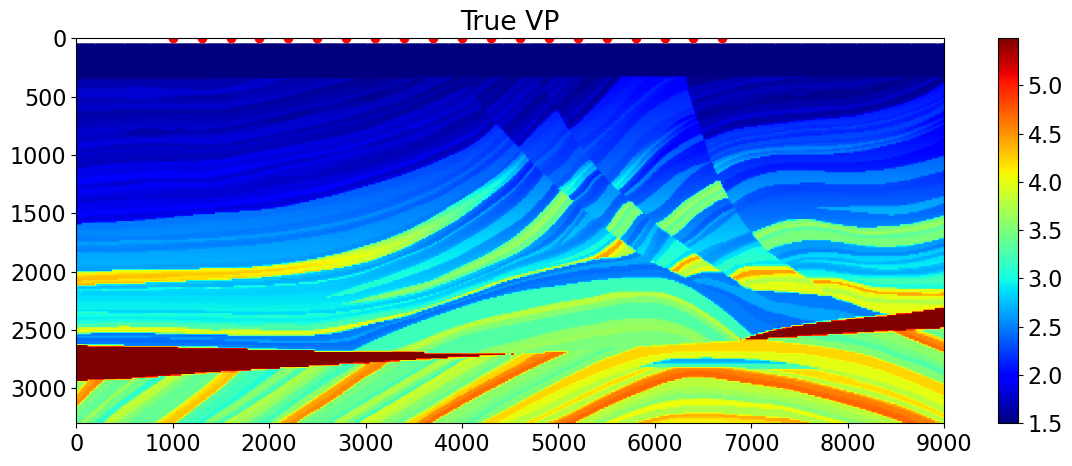

In [6]:
# Load the true model
vp_true = np.fromfile(velocity_file, np.float32).reshape(par['nz'], par['nx']).T
msk = create_mask(vp_true, 1.52) # get the mask for the water layer 

m_vmin, m_vmax = np.percentile(vp_true, [2,98]) 

plt.figure(figsize=(14, 5))
plt.imshow(vp_true.T, vmin=m_vmin, vmax=m_vmax, cmap='jet', 
           extent=(x[0], x[-1], z[-1], z[0]))
plt.colorbar()
plt.scatter(x_r[:,0], x_r[:,1], c='w')
plt.scatter(x_s[:,0], x_s[:,1], c='r')
plt.title('True VP')
plt.axis('tight');

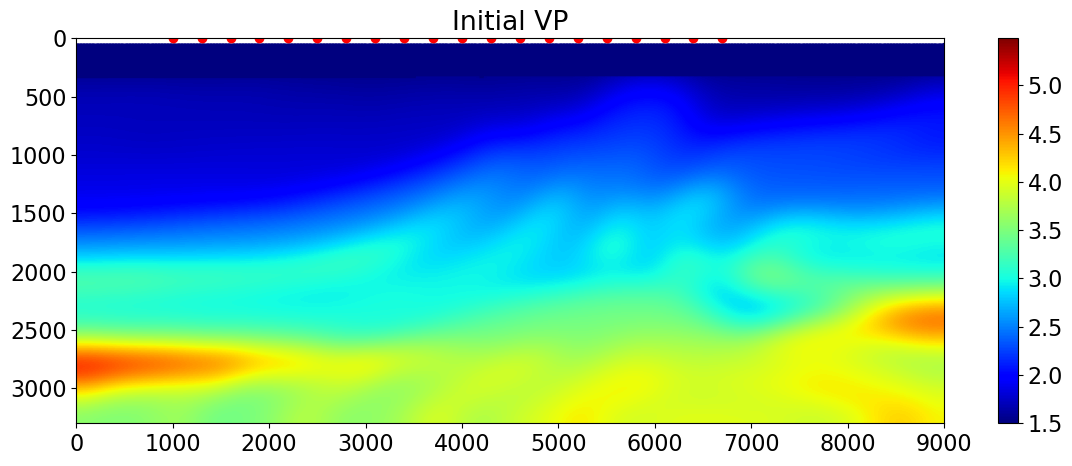

In [7]:
# Initial model for FWI by smoothing the true model
vp_init = gaussian_filter(vp_true, sigma=[15,10])
vp_init = vp_init * msk  # to preserve the water layer  
vp_init[vp_init == 0] = 1.5

plt.figure(figsize=(14, 5))
plt.imshow(vp_init.T, vmin=m_vmin, vmax=m_vmax, cmap='jet', 
extent=(x[0], x[-1], z[-1], z[0]))
plt.colorbar()
plt.scatter(x_r[:,0], x_r[:,1], c='w')
plt.scatter(x_s[:,0], x_s[:,1], c='r')
plt.title('Initial VP')
plt.axis('tight');

## Data modelling

In [8]:
amod = AcousticWave2D(shape, origin, spacing, 
                      x_s[:, 0], x_s[:, 1], x_r[:, 0], x_r[:, 1], 
                      0., tmax,
                      vp=vp_true * 1e3, 
                      src_type="Ricker", f0=par['freq'],
                      space_order=space_order, nbl=nbl);

In [9]:
# Model data
dobs = amod.mod_allshots()

  0%|          | 0/20 [00:00<?, ?it/s]

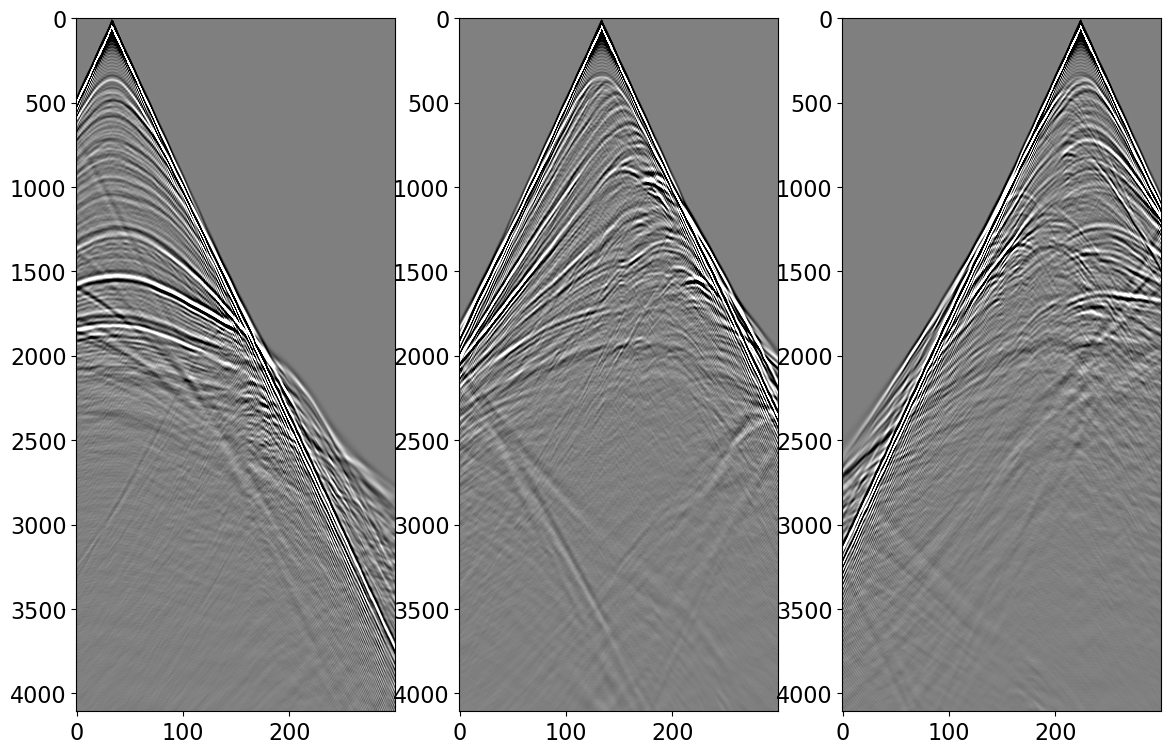

In [10]:
# Plot shot gathers
d_vmin, d_vmax = np.percentile(np.hstack(dobs).ravel(), [2, 98])

fig, axs = plt.subplots(1, 3, figsize=(14, 9))
for ax, ishot in zip(axs, [0, par['ns']//2, par['ns']-1]):
    ax.imshow(dobs[ishot], aspect='auto', cmap='gray',
              vmin=-d_vmax, vmax=d_vmax)

## Inversion with L-BFGS

In [11]:
# Params (3stages)
frequencies = [7, 12, 70]
nfilts = [7, 7, 7]
#ftol = [1e-10, 1e-10, 1e-10]
#maxiter = [50, 50, 50]
#maxfun = [200, 200, 200]

Working with frequency 1/3


  0%|          | 0/20 [00:00<?, ?it/s]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =       132821     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.31126D+04    |proj g|=  3.01759D+01


 This problem is unconstrained.


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate    1    f=  2.04308D+04    |proj g|=  2.75543D+01


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


At iterate    2    f=  1.33160D+04    |proj g|=  2.22754D+01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate    3    f=  1.16265D+04    |proj g|=  1.73659D+01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate    4    f=  1.07814D+04    |proj g|=  1.07959D+01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate    5    f=  9.58744D+03    |proj g|=  1.64593D+01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate    6    f=  8.98074D+03    |proj g|=  9.25866D+00


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate    7    f=  7.86719D+03    |proj g|=  7.23792D+00


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate    8    f=  7.17719D+03    |proj g|=  7.78936D+00


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate    9    f=  6.45903D+03    |proj g|=  1.15257D+01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   10    f=  5.75779D+03    |proj g|=  8.96751D+00


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   11    f=  5.28692D+03    |proj g|=  5.55414D+00


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   12    f=  4.95827D+03    |proj g|=  8.76900D+00


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   13    f=  4.51923D+03    |proj g|=  6.72955D+00


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   14    f=  4.33625D+03    |proj g|=  1.57337D+01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   15    f=  3.91451D+03    |proj g|=  5.57478D+00


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   16    f=  3.80150D+03    |proj g|=  4.13695D+00


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   17    f=  3.56732D+03    |proj g|=  4.62841D+00


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   18    f=  3.31248D+03    |proj g|=  7.41971D+00


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   19    f=  3.11100D+03    |proj g|=  7.43102D+00


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   20    f=  2.95122D+03    |proj g|=  3.69276D+00


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   21    f=  2.75967D+03    |proj g|=  4.20498D+00


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   22    f=  2.56616D+03    |proj g|=  5.77490D+00


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   23    f=  2.40010D+03    |proj g|=  6.42923D+00


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   24    f=  2.27311D+03    |proj g|=  3.09780D+00


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   25    f=  2.16084D+03    |proj g|=  3.30939D+00


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   26    f=  1.99808D+03    |proj g|=  2.69926D+00


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   27    f=  1.90395D+03    |proj g|=  9.29287D+00


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   28    f=  1.78291D+03    |proj g|=  2.60819D+00


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   29    f=  1.74312D+03    |proj g|=  2.20844D+00


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   30    f=  1.63866D+03    |proj g|=  3.87594D+00


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   31    f=  1.57056D+03    |proj g|=  9.09623D+00


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   32    f=  1.48354D+03    |proj g|=  2.28141D+00


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   33    f=  1.43063D+03    |proj g|=  2.21587D+00


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   34    f=  1.35642D+03    |proj g|=  2.68493D+00


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   35    f=  1.31117D+03    |proj g|=  3.59453D+00


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   36    f=  1.23915D+03    |proj g|=  2.52442D+00


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   37    f=  1.16763D+03    |proj g|=  1.91392D+00


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   38    f=  1.09436D+03    |proj g|=  2.30031D+00


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   39    f=  1.04533D+03    |proj g|=  2.40218D+00


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   40    f=  1.01467D+03    |proj g|=  2.06615D+00


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   41    f=  9.78989D+02    |proj g|=  1.74420D+00


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   42    f=  9.30961D+02    |proj g|=  3.47100D+00


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   43    f=  8.80648D+02    |proj g|=  4.26003D+00


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   44    f=  8.43896D+02    |proj g|=  1.64039D+00


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   45    f=  8.17254D+02    |proj g|=  2.47643D+00


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   46    f=  7.79972D+02    |proj g|=  3.42979D+00


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   47    f=  7.55980D+02    |proj g|=  2.55010D+00


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   48    f=  7.28547D+02    |proj g|=  1.38231D+00


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   49    f=  7.05694D+02    |proj g|=  1.56030D+00


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   50    f=  6.78548D+02    |proj g|=  1.56187D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
*****     50     54      1     0     0   1.562D+00   6.785D+02
  F =   678.54791363997833     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Working with frequency 2/3


  0%|          | 0/20 [00:00<?, ?it/s]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =       132821     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.48368D+04    |proj g|=  2.89469D+01


 This problem is unconstrained.


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


At iterate    1    f=  1.45514D+04    |proj g|=  3.00749D+01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate    2    f=  1.40778D+04    |proj g|=  4.14902D+01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate    3    f=  1.30384D+04    |proj g|=  4.79496D+01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate    4    f=  1.20070D+04    |proj g|=  9.00372D+01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate    5    f=  1.11427D+04    |proj g|=  6.32370D+01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate    6    f=  1.06237D+04    |proj g|=  3.35696D+01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate    7    f=  1.03089D+04    |proj g|=  3.04261D+01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate    8    f=  9.72394D+03    |proj g|=  2.73229D+01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate    9    f=  9.07943D+03    |proj g|=  3.21117D+01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   10    f=  8.72804D+03    |proj g|=  8.97775D+01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   11    f=  8.21134D+03    |proj g|=  2.65562D+01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   12    f=  7.91854D+03    |proj g|=  2.33123D+01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   13    f=  7.46095D+03    |proj g|=  2.44939D+01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   14    f=  7.16056D+03    |proj g|=  6.92933D+01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   15    f=  6.64685D+03    |proj g|=  2.53641D+01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   16    f=  6.41957D+03    |proj g|=  2.18001D+01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   17    f=  6.20321D+03    |proj g|=  2.46333D+01


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   18    f=  6.04846D+03    |proj g|=  3.80612D+01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   19    f=  5.86662D+03    |proj g|=  2.85990D+01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   20    f=  5.51099D+03    |proj g|=  2.34320D+01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   21    f=  5.31167D+03    |proj g|=  3.67363D+01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   22    f=  5.11255D+03    |proj g|=  1.87011D+01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   23    f=  4.92803D+03    |proj g|=  1.26825D+01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   24    f=  4.76724D+03    |proj g|=  3.97882D+01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   25    f=  4.61218D+03    |proj g|=  3.13028D+01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   26    f=  4.48197D+03    |proj g|=  2.34381D+01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   27    f=  4.28798D+03    |proj g|=  2.15543D+01


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   28    f=  4.19300D+03    |proj g|=  2.46679D+01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   29    f=  4.08654D+03    |proj g|=  2.65082D+01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   30    f=  3.97402D+03    |proj g|=  1.34854D+01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   31    f=  3.88035D+03    |proj g|=  1.84018D+01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   32    f=  3.71609D+03    |proj g|=  1.52324D+01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   33    f=  3.59122D+03    |proj g|=  1.39071D+01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   34    f=  3.48257D+03    |proj g|=  1.68584D+01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   35    f=  3.39462D+03    |proj g|=  1.25518D+01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   36    f=  3.32161D+03    |proj g|=  1.32143D+01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   37    f=  3.22299D+03    |proj g|=  3.04492D+01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   38    f=  3.13827D+03    |proj g|=  2.29069D+01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   39    f=  3.06494D+03    |proj g|=  1.16006D+01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   40    f=  3.00055D+03    |proj g|=  1.40158D+01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   41    f=  2.95102D+03    |proj g|=  8.71650D+00


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   42    f=  2.87671D+03    |proj g|=  1.47974D+01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   43    f=  2.80539D+03    |proj g|=  1.24719D+01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   44    f=  2.72684D+03    |proj g|=  8.57150D+00


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   45    f=  2.66779D+03    |proj g|=  1.49194D+01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   46    f=  2.61000D+03    |proj g|=  1.14473D+01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   47    f=  2.54748D+03    |proj g|=  1.53528D+01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   48    f=  2.48745D+03    |proj g|=  1.36089D+01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   49    f=  2.42308D+03    |proj g|=  1.17282D+01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   50    f=  2.36944D+03    |proj g|=  1.37347D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
*****     50     54      1     0     0   1.373D+01   2.369D+03
  F =   2369.4400973264019     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Working with frequency 3/3


  0%|          | 0/20 [00:00<?, ?it/s]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =       132821     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.84985D+04    |proj g|=  1.21458D+02


 This problem is unconstrained.


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


At iterate    1    f=  3.81392D+04    |proj g|=  1.26009D+02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate    2    f=  3.73283D+04    |proj g|=  1.35455D+02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate    3    f=  3.64436D+04    |proj g|=  1.25772D+02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate    4    f=  3.44904D+04    |proj g|=  1.42178D+02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate    5    f=  3.21114D+04    |proj g|=  1.92192D+02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate    6    f=  3.02279D+04    |proj g|=  2.17194D+02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate    7    f=  2.89285D+04    |proj g|=  1.07621D+02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate    8    f=  2.82842D+04    |proj g|=  1.23699D+02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate    9    f=  2.74644D+04    |proj g|=  1.01973D+02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   10    f=  2.57317D+04    |proj g|=  1.56863D+02


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   11    f=  2.49374D+04    |proj g|=  1.45199D+02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   12    f=  2.39053D+04    |proj g|=  1.38303D+02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   13    f=  2.31301D+04    |proj g|=  1.40904D+02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   14    f=  2.26707D+04    |proj g|=  2.15154D+02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   15    f=  2.15716D+04    |proj g|=  1.03890D+02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   16    f=  2.09657D+04    |proj g|=  6.05277D+01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   17    f=  2.04276D+04    |proj g|=  7.54479D+01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   18    f=  1.97257D+04    |proj g|=  8.27500D+01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   19    f=  1.93812D+04    |proj g|=  2.97874D+02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   20    f=  1.77898D+04    |proj g|=  1.06988D+02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   21    f=  1.74581D+04    |proj g|=  9.09491D+01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   22    f=  1.69244D+04    |proj g|=  7.75008D+01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   23    f=  1.63803D+04    |proj g|=  8.24759D+01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   24    f=  1.55719D+04    |proj g|=  1.54138D+02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   25    f=  1.53072D+04    |proj g|=  2.14236D+02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   26    f=  1.45676D+04    |proj g|=  7.38057D+01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   27    f=  1.42931D+04    |proj g|=  8.10315D+01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   28    f=  1.38945D+04    |proj g|=  7.99980D+01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   29    f=  1.36670D+04    |proj g|=  1.28342D+02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   30    f=  1.31936D+04    |proj g|=  6.81500D+01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   31    f=  1.29329D+04    |proj g|=  6.46121D+01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   32    f=  1.26052D+04    |proj g|=  7.87586D+01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   33    f=  1.20450D+04    |proj g|=  8.27484D+01


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   34    f=  1.19189D+04    |proj g|=  5.62426D+01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   35    f=  1.15953D+04    |proj g|=  8.82129D+01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   36    f=  1.13178D+04    |proj g|=  6.69776D+01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   37    f=  1.09642D+04    |proj g|=  2.08303D+02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   38    f=  1.06158D+04    |proj g|=  5.71349D+01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   39    f=  1.04523D+04    |proj g|=  5.52596D+01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   40    f=  1.02151D+04    |proj g|=  4.46956D+01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   41    f=  1.00665D+04    |proj g|=  8.59968D+01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   42    f=  9.88365D+03    |proj g|=  7.37178D+01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   43    f=  9.74060D+03    |proj g|=  4.01555D+01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   44    f=  9.58477D+03    |proj g|=  4.58315D+01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   45    f=  9.30565D+03    |proj g|=  4.39786D+01


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   46    f=  9.22493D+03    |proj g|=  5.77987D+01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   47    f=  9.00677D+03    |proj g|=  7.23824D+01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   48    f=  8.89037D+03    |proj g|=  6.32271D+01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   49    f=  8.73447D+03    |proj g|=  3.63691D+01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   50    f=  8.56806D+03    |proj g|=  4.72431D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
*****     50     55      1     0     0   4.724D+01   8.568D+03
  F =   8568.0600098188042     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


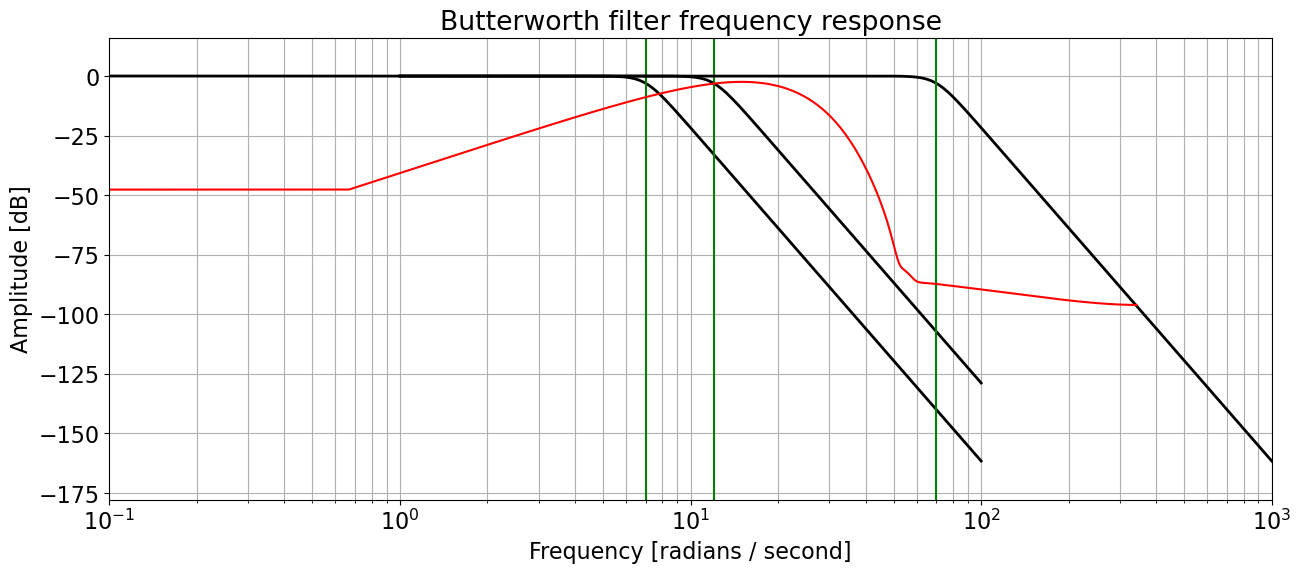

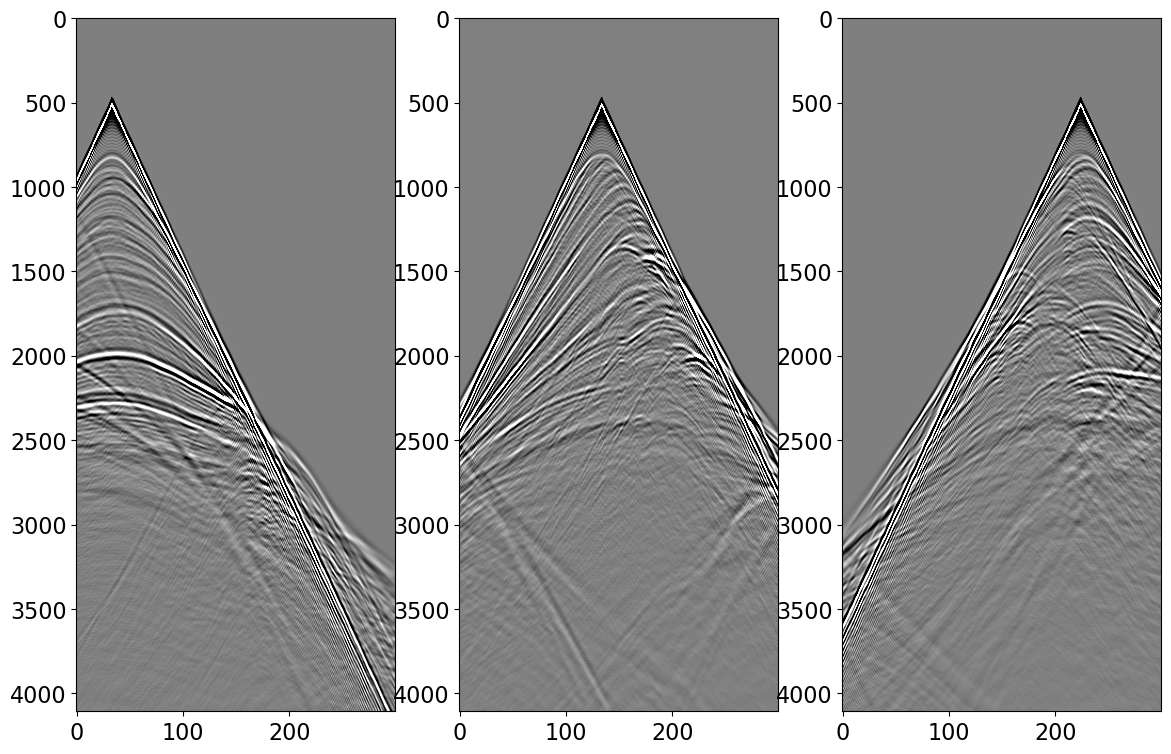

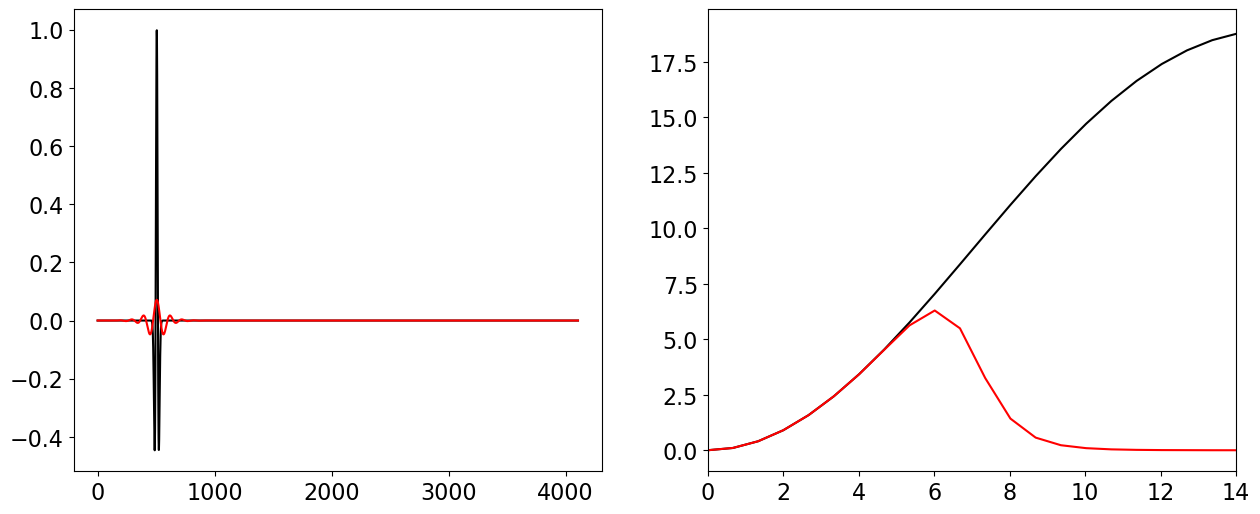

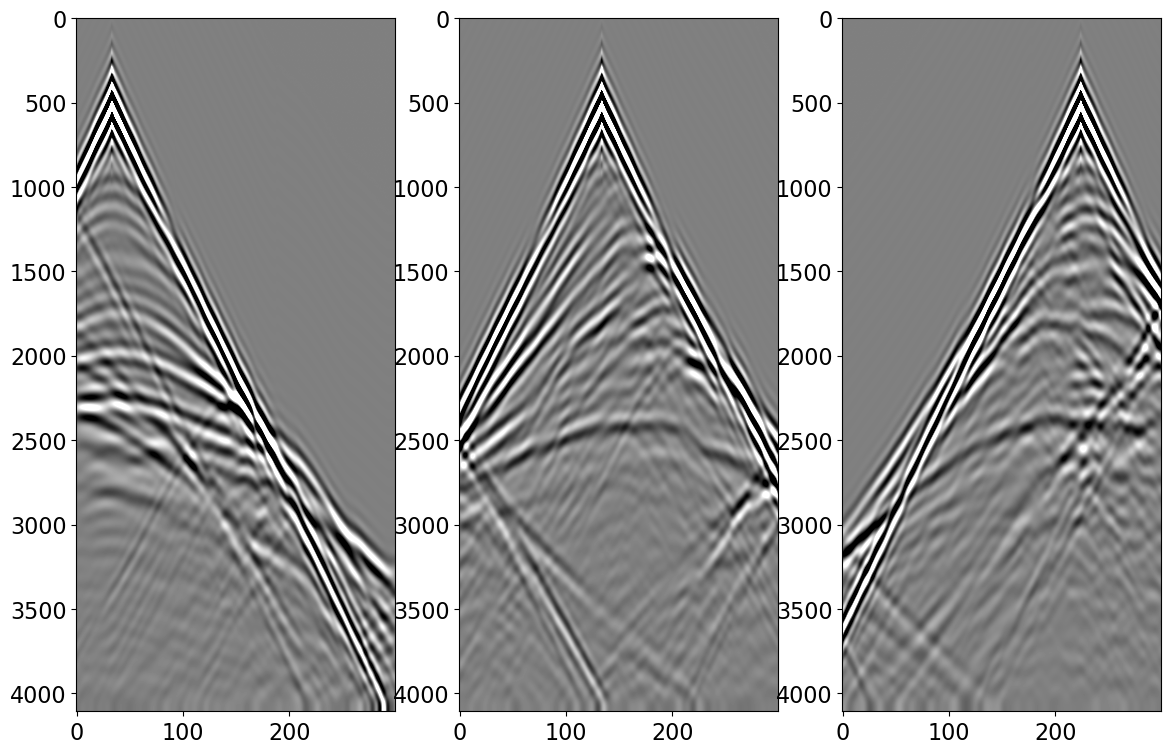

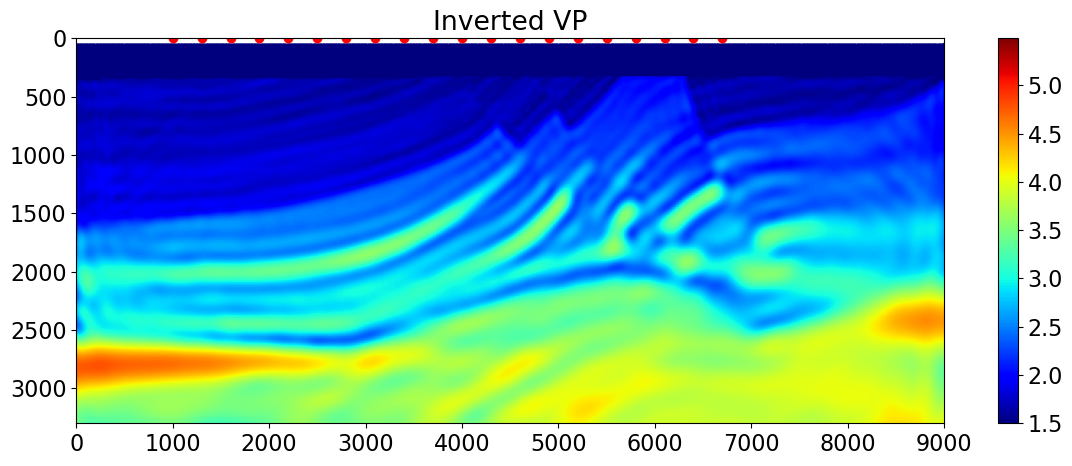

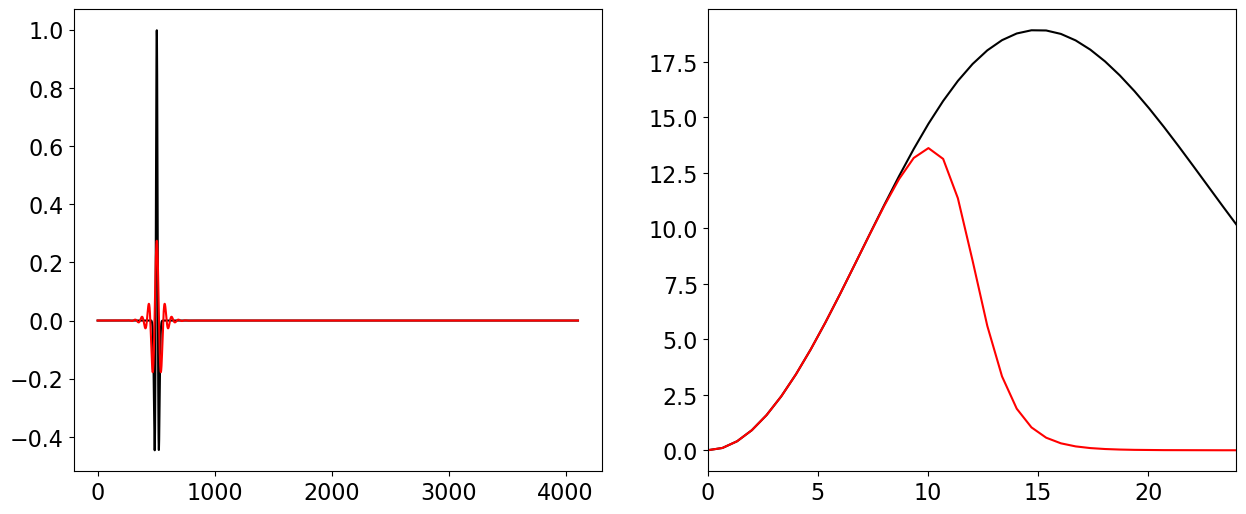

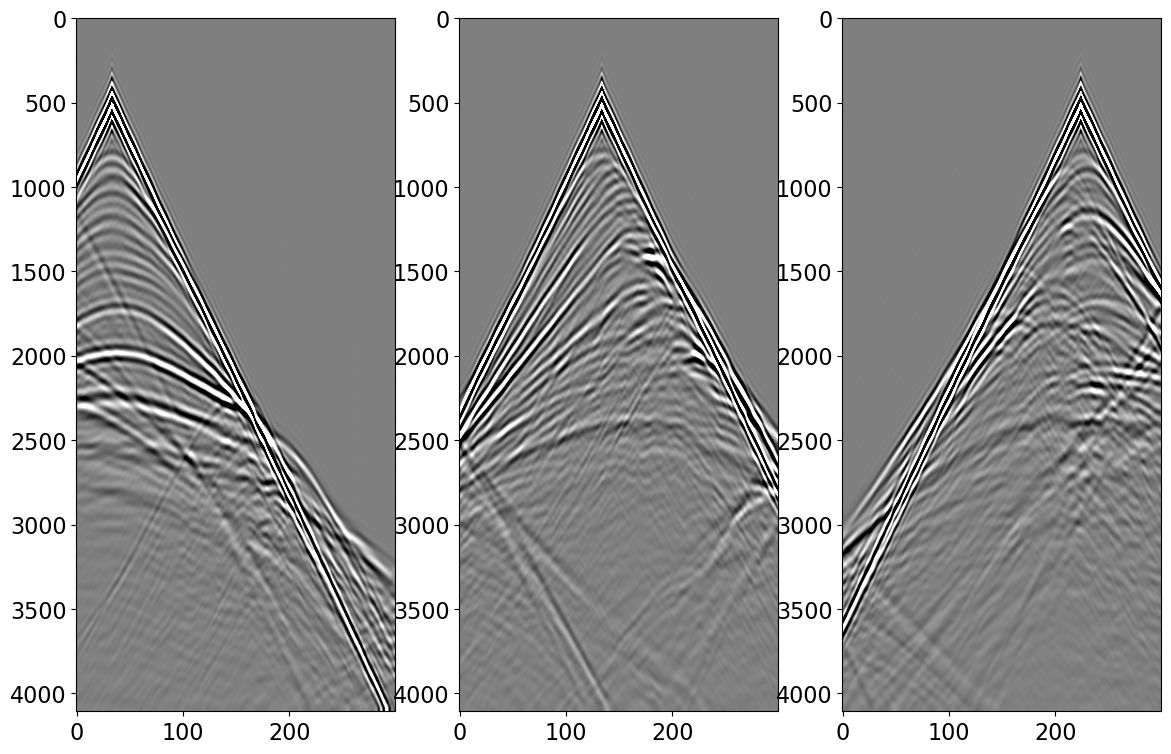

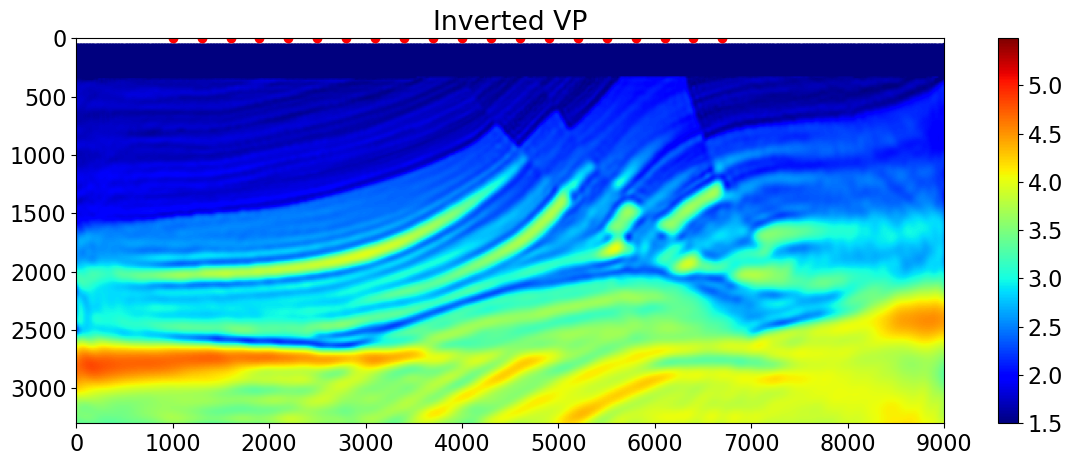

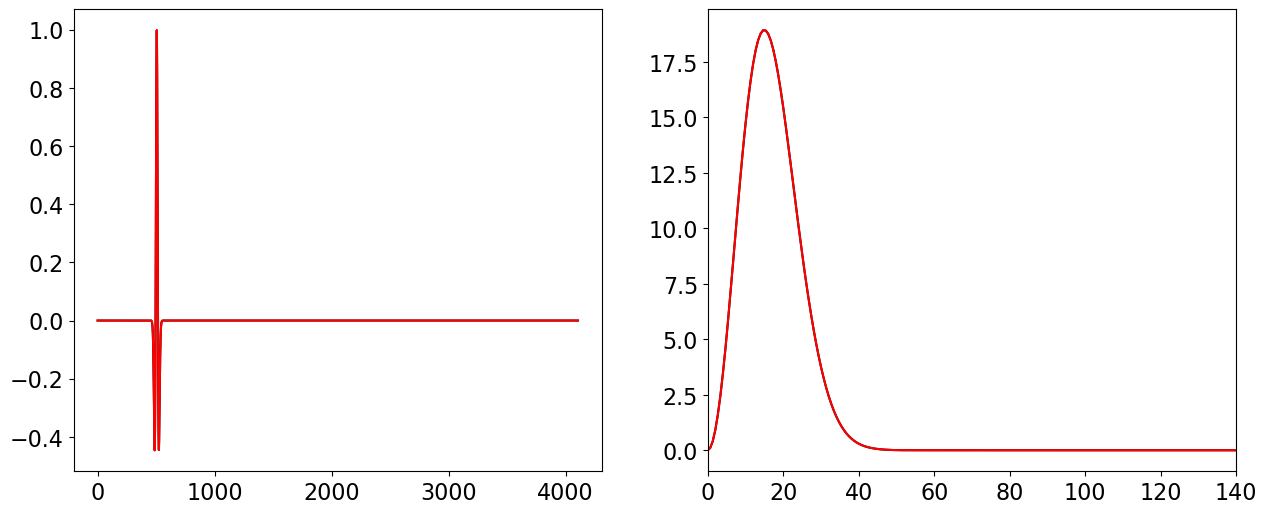

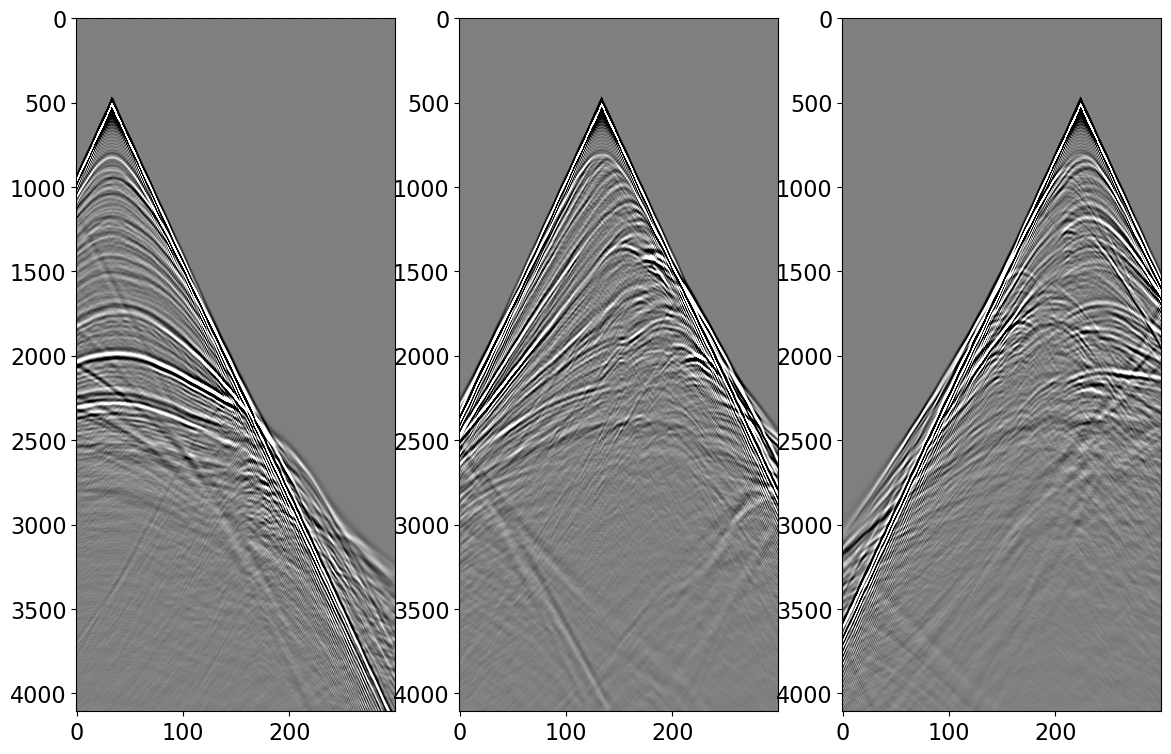

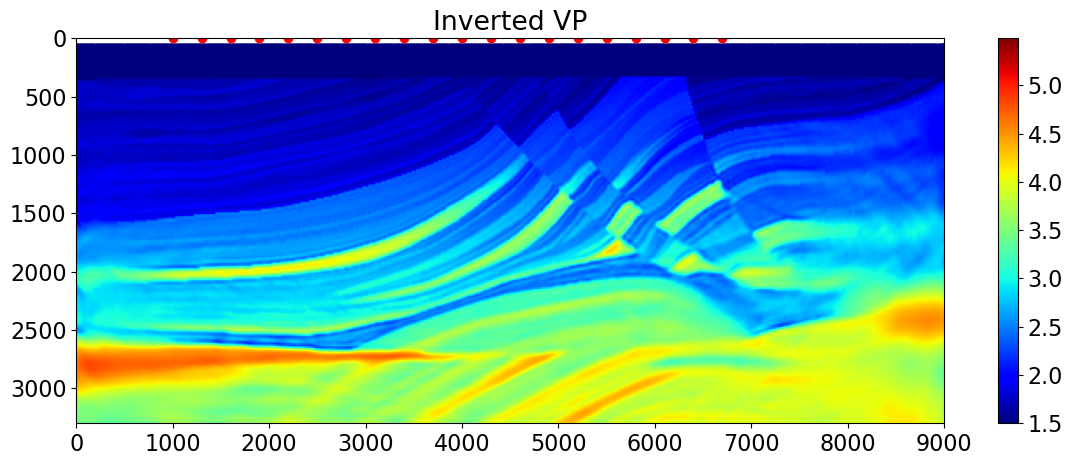

In [12]:
# Invert
wav = amod.geometry.src.wavelet
postprocess = PostProcessVP(scaling=1, mask=msk)

vp_error_hist = []
afwi = AcousticFWI2D(par, vp_init=vp_init * 1e3, vp_range=(vp_true.min() * 1e3, vp_true.max() * 1e3),
                     wav=wav, loss=L2, lossop=Identity(int(np.prod(dobs.shape[1:]))),
                     space_order=4, nbl=20, 
                     firstscaling=False, postprocess=postprocess, 
                     frequencies=frequencies, nfilts=nfilts, nfft=2**10,
                     solver='L-BFGS-B',
                     kwargs_solver={'ftol':1e-10, 'maxiter':50, 'maxfun':200, 'disp':True},
                     callback=lambda x: fwi_callback(x, vp=vp_true, vp_error=vp_error_hist))

vp_inv, loss_hist, nl = afwi.run(dobs, plotflag=True, vlims=(m_vmin, m_vmax))

In [13]:
nl

  message: STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
  success: False
   status: 1
      fun: 8568.060009818804
        x: [ 1.500e+00  1.500e+00 ...  3.840e+00  3.874e+00]
      nit: 50
      jac: [ 0.000e+00  0.000e+00 ...  4.338e-01  4.634e-01]
     nfev: 55
     njev: 55
 hess_inv: <132821x132821 LbfgsInvHessProduct with dtype=float64>

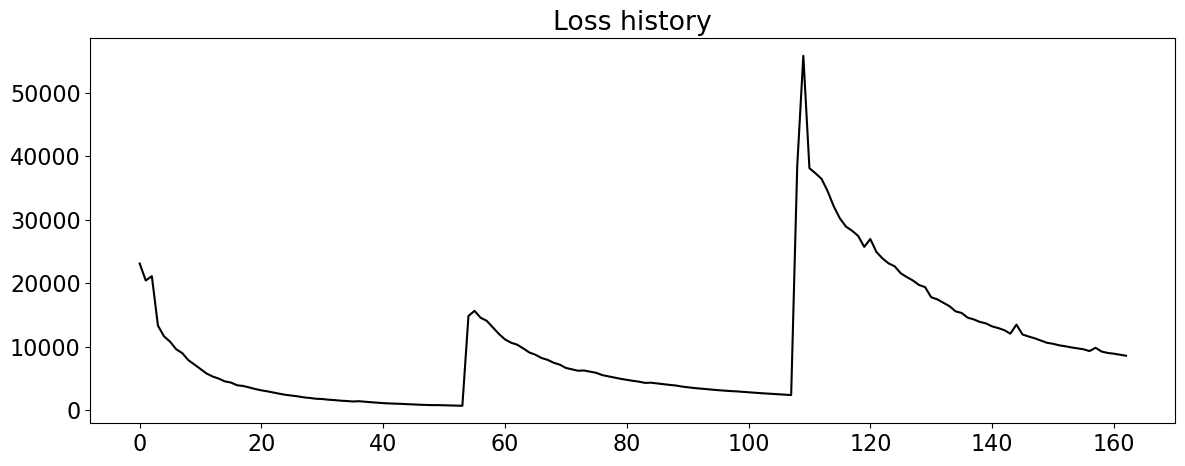

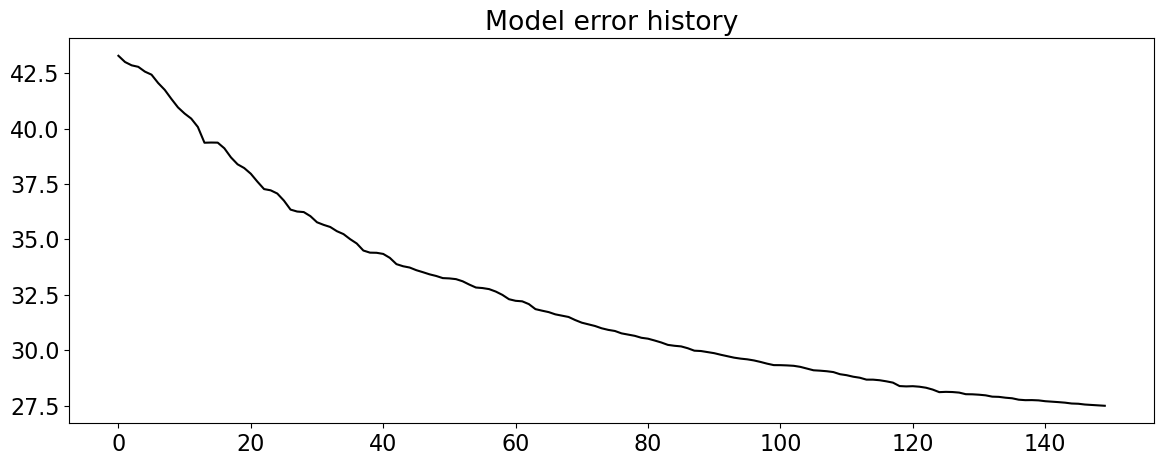

In [14]:
plt.figure(figsize=(14, 5))
plt.plot(list(chain.from_iterable(loss_hist)), 'k')
plt.title('Loss history')

plt.figure(figsize=(14, 5))
plt.plot(vp_error_hist, 'k')
plt.title('Model error history');

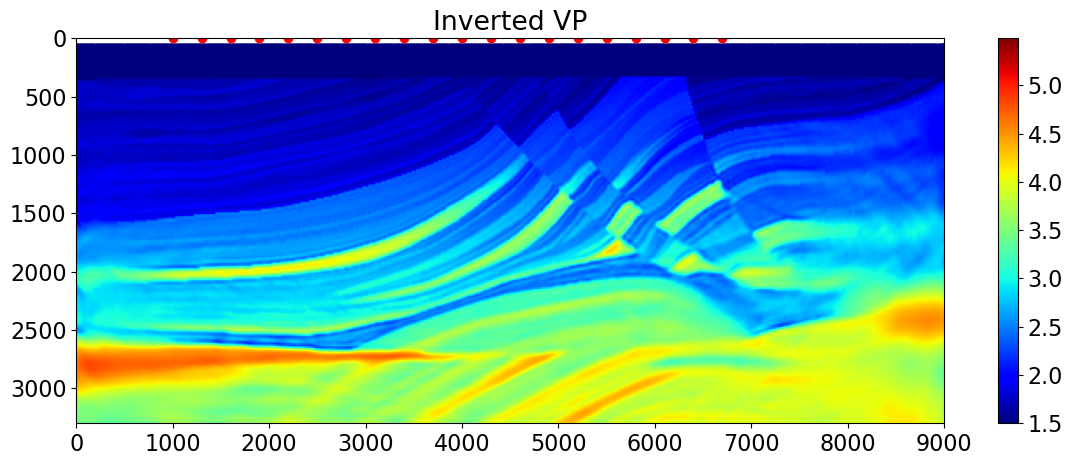

In [15]:
vp_inv = nl.x.reshape(shape)

plt.figure(figsize=(14, 5))
plt.imshow(vp_inv.T, vmin=m_vmin, vmax=m_vmax, cmap='jet', extent=(x[0], x[-1], z[-1], z[0]))
plt.colorbar()
plt.scatter(x_r[:,0], x_r[:,1], c='w')
plt.scatter(x_s[:,0], x_s[:,1], c='r')
plt.title('Inverted VP')
plt.axis('tight');

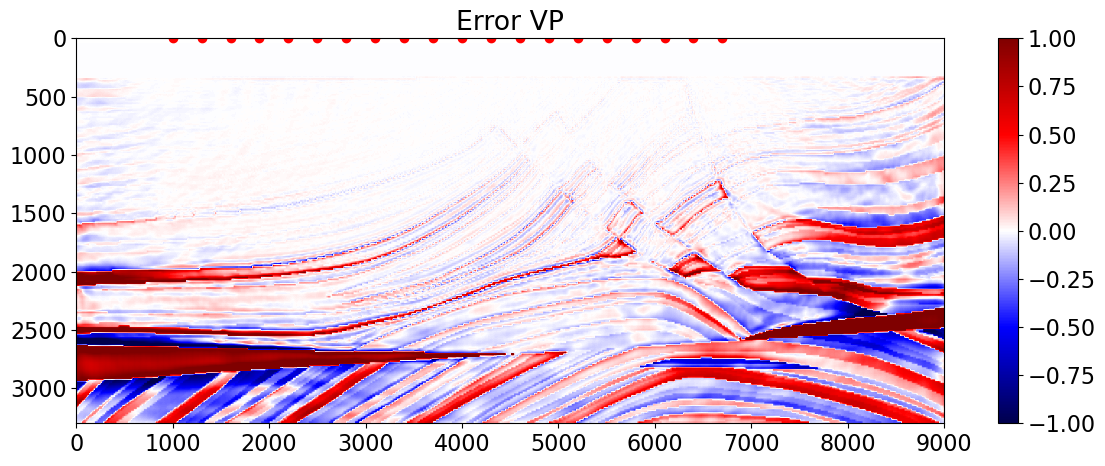

In [16]:
plt.figure(figsize=(14, 5))
plt.imshow(vp_true.T-vp_inv.T, vmin=-1, vmax=1, cmap='seismic', extent=(x[0], x[-1], z[-1], z[0]))
plt.colorbar()
plt.scatter(x_r[:,0], x_r[:,1], c='w')
plt.scatter(x_s[:,0], x_s[:,1], c='r')
plt.title('Error VP')
plt.axis('tight');

In [17]:
# Model data with inverted velocity model and compare with observed data
ainvfinal = AcousticWave2D(shape, origin, spacing, 
                           x_s[:, 0], x_s[:, 1], x_r[:, 0], x_r[:, 1], 
                           0., tmax,  
                           vp=vp_inv * 1e3, 
                           src_type="Ricker", f0=par['freq'],
                           space_order=space_order, nbl=nbl)
#plot_velocity(ainvfinal.model, ainvfinal.geometry.src_positions, 
#              ainvfinal.geometry.rec_positions)

dinv = ainvfinal.mod_allshots(dt=amod.geometry.dt)

  0%|          | 0/20 [00:00<?, ?it/s]

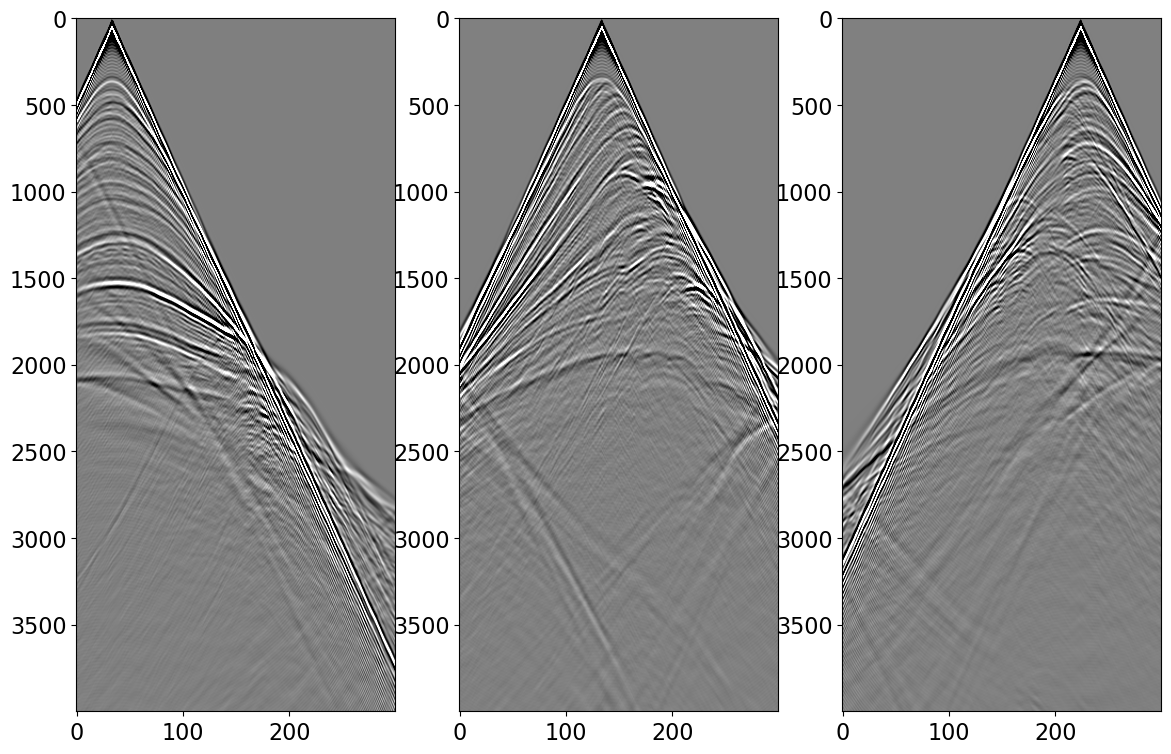

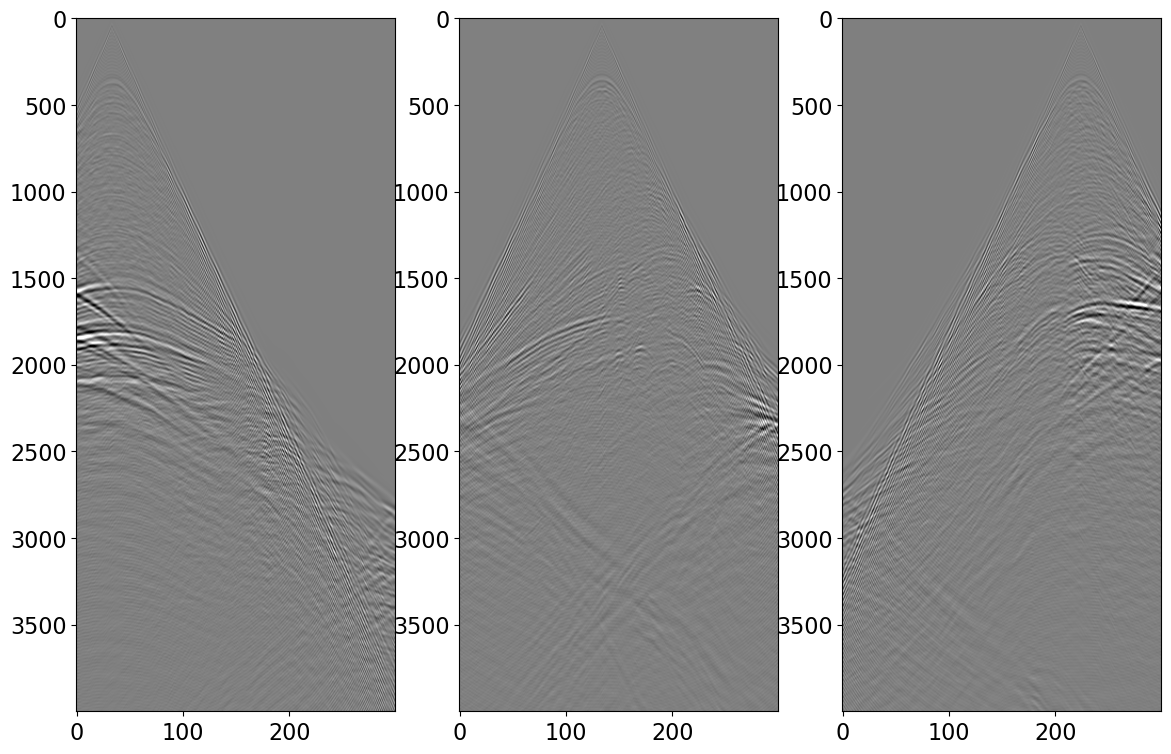

In [18]:
# Display modelling error
ntmax = 4000
d_vmin, d_vmax = np.percentile(np.hstack(dinv).ravel(), [2, 98])

fig, axs = plt.subplots(1, 3, figsize=(14, 9))
for ax, ishot in zip(axs, [0, par['ns']//2, par['ns']-1]):
    ax.imshow(dinv[ishot, :ntmax], aspect='auto', cmap='gray',
              vmin=-d_vmax, vmax=d_vmax)

fig, axs = plt.subplots(1, 3, figsize=(14, 9))
for ax, ishot in zip(axs, [0, par['ns']//2, par['ns']-1]):
    ax.imshow(dobs[ishot, :ntmax] - dinv[ishot, :ntmax], aspect='auto', cmap='gray',
              vmin=-d_vmax, vmax=d_vmax)